In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('../data/final.csv', index_col=0)
df.shape

(30700, 21)

In [3]:
df['number_of_engines'].value_counts()

1    22856
2     3912
0     3762
4      110
3       58
8        1
6        1
Name: number_of_engines, dtype: int64

In [4]:
# get fatality rate for every model in our dataset
injury_counts = df.groupby('model')['injury_severity'].value_counts().unstack(fill_value=0)
injury_counts['fatality_rate'] = injury_counts['fatal'] / (injury_counts['fatal'] + injury_counts['non-fatal'])
injury_counts.head()

injury_severity,fatal,non-fatal,fatality_rate
model,,,
(Ex) Rv6,1,0,1.0
01,1,0,1.0
01A,0,1,0.0
058A,0,1,0.0
058B,0,3,0.0


# Commercial comparison: Boeing vs Airbus
- 1526 accident reports for Boeing
- 266 accident reports for Airbus

# Injuries per crash: Boeing v Airbus

In [48]:
boeing_rows = df[df['make'] == 'Boeing']

# for plotting average injury data for boeing
boeing_agg = boeing_rows[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].mean().to_frame().T
boeing_agg

,total_fatal_injuries,total_serious_injuries,total_minor_injuries
0,2.660207,0.923127,0.338501


In [52]:
airbus_rows = df[df['make'] == 'Airbus']

# for plotting average injury data for boeing
airbus_agg = airbus_rows[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].mean().to_frame().reset_index()
airbus_agg

,index,0
0,total_fatal_injuries,4.910448
1,total_serious_injuries,0.686567
2,total_minor_injuries,0.264925


<AxesSubplot:>

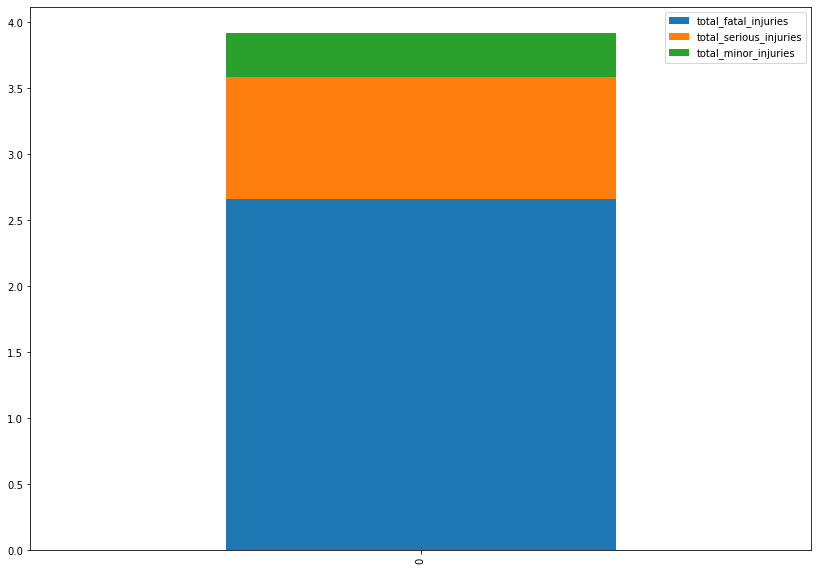

In [57]:
boeing_agg.plot(figsize=(14,10), kind='bar')

plt.title('Injury Severity: Boeing vs Airbus', fontsize=24)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Injury Category', )
plt.xticks([])  # Remove x-axis tick as there's only one group of bars
plt.legend(title='Injury Severity')

plt.show()

# Fatality rate as a manufacturer (all models): Boeing vs Airbus
- basically the same between the two (95% non-fatal)

In [7]:
boeing_fatality = boeing_rows['injury_severity'].value_counts(normalize=True)
print(f'count of boeing_rows: {boeing_rows.shape[0]}\n\nFatality-rate:')
boeing_fatality

count of boeing_rows: 1548

Fatality-rate:


non-fatal    0.956072
fatal        0.043928
Name: injury_severity, dtype: float64

### 'Reciprocating' engine type seems to have noticeably higher fatality rate. Does not support Boeing arg

In [8]:
reciprocating = boeing_rows[boeing_rows['engine_type'] == 'Reciprocating']['injury_severity'].value_counts(normalize=True)
reciprocating

non-fatal    0.895652
fatal        0.104348
Name: injury_severity, dtype: float64

In [9]:
airbus_fatality = airbus_rows['injury_severity'].value_counts(normalize=True)
print(f'count of airbus_rows: {airbus_rows.shape[0]}\n\nFatality-rate:')
airbus_fatality

count of airbus_rows: 268

Fatality-rate:


non-fatal    0.955224
fatal        0.044776
Name: injury_severity, dtype: float64

# top 5 Boeing planes vs top 5 Airbus planes

- 97% of Boeing crashes are non-fatal
- 95% of Airbus crashes are non-fatal

In [10]:
names = boeing_rows['model'].value_counts().index[:5]
top_5_boeing_models  = df[df['model'].isin(names)]
top_5_boeing_models['injury_severity'].value_counts(normalize=True)

non-fatal    0.974633
fatal        0.025367
Name: injury_severity, dtype: float64

In [11]:
names = airbus_rows['model'].value_counts().index[:5]
top_5_airbus_models  = df[df['model'].isin(names)]
top_5_airbus_models['injury_severity'].value_counts(normalize=True)

non-fatal    0.955056
fatal        0.044944
Name: injury_severity, dtype: float64

## Look at fatality rates of those specific models

In [12]:
top_5_boeing_stats = top_5_boeing_models.groupby(['make', 'model']).size().reset_index(name='count')
top_5_boeing_stats = top_5_boeing_stats.merge(injury_counts['fatality_rate'], left_on='model', how='left', right_index=True)
top_3_boeing_stats = top_5_boeing_stats[top_5_boeing_stats['fatality_rate'] != 0].sort_values(by='fatality_rate')
top_3_boeing_stats

,make,model,count,fatality_rate
3,Boeing,767,59,0.016949
1,Boeing,747,75,0.026667
0,Boeing,737,477,0.033543


In [13]:
top_5_airbus_stats = top_5_airbus_models.groupby(['make', 'model']).size().reset_index(name='count')
top_5_airbus_stats = top_5_airbus_stats.merge(injury_counts['fatality_rate'], left_on='model', how='left', right_index=True)
top_3_airbus_stats = top_5_airbus_stats[top_5_airbus_stats['fatality_rate'] != 0]

# combine bottom 3 (duplicate) models -> agg takes dict {col : kwarg}
top_3_airbus_stats = top_3_airbus_stats.groupby('model').agg({'make': 'first',
                                                              'count': 'sum',
                                                              'fatality_rate': 'mean'}).reset_index().sort_values(by='fatality_rate')

top_3_airbus_stats

,model,make,count,fatality_rate
0,A320,Airbus,93,0.043011
2,A330,Airbus,37,0.054054
1,A321,Airbus,20,0.100000


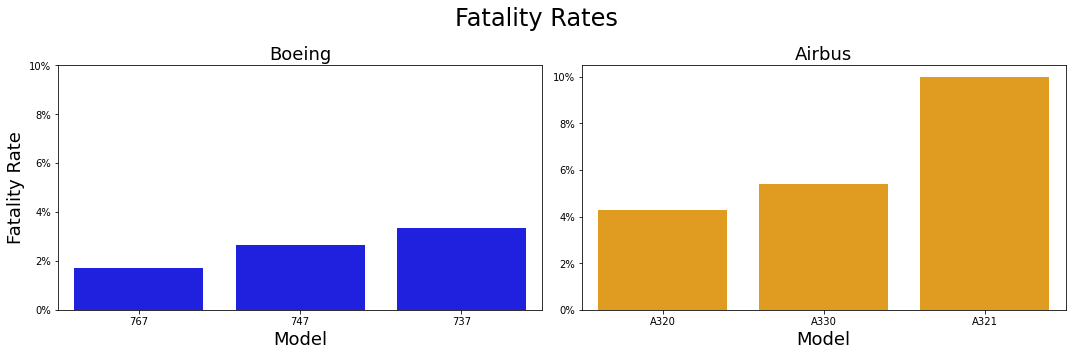

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

locations = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
labels = ['0%', '2%', '4%', '6%', '8%', '10%']

sns.barplot(data=top_3_boeing_stats, x='model', y='fatality_rate', ax=axes[0], color='blue')
axes[0].set_title('Boeing', fontsize=18)
axes[0].set_xlabel('Model', fontsize=18)
axes[0].set_ylabel('Fatality Rate', fontsize=18)

axes[0].set_yticks(locations)
axes[0].set_yticklabels(labels)

sns.barplot(data=top_3_airbus_stats, x='model', y='fatality_rate', ax=axes[1], color='orange')
axes[1].set_title('Airbus', fontsize=18)
axes[1].set_xlabel('Model', fontsize=18)
axes[1].set_ylabel('')

axes[1].set_yticks(locations)
axes[1].set_yticklabels(labels)

fig.suptitle('Fatality Rates', fontsize=24)

plt.tight_layout()

# plt.savefig('plots/boeing_vs_airbus.jpg');

In [15]:
# the top 100 models with the most accident reports
top_100 = pd.read_csv('../data/top_100_models.csv', index_col=0)
top_100

,make,model,count,fatality_rate,make_model,num_seats,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,avg_fatal_injuries,avg_serious_injuries,avg_minor_injuries,avg_uninjured,Substantial,Destroyed,Unknown,Minor
6082,Piper,Pa34,60,0.516667,Piper Pa34,6,73,19,11,52,1.216667,0.316667,0.183333,0.866667,0.683333,0.250000,0.050000,0.016667
5987,Piper,Pa23250,64,0.562500,Piper Pa23250,5,81,7,11,58,1.265625,0.109375,0.171875,0.906250,0.671875,0.312500,0.000000,0.015625
835,Beech,58,85,0.563830,Beech 58,6,111,13,8,93,1.305882,0.152941,0.094118,1.094118,0.691489,0.255319,0.010638,0.042553
6569,Robinson,R44,62,0.575758,Robinson R44,4,83,26,13,38,1.338710,0.419355,0.209677,0.612903,0.469697,0.469697,0.060606,0.000000
6084,Piper,Pa34200T,56,0.607143,Piper Pa34200T,6,48,7,5,55,0.857143,0.125000,0.089286,0.982143,0.535714,0.410714,0.053571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,Cessna,182A,59,0.966102,Cessna 182A,4,5,20,15,70,0.084746,0.338983,0.254237,1.186441,0.966102,0.033898,0.000000,0.000000
1248,Boeing,737,477,0.966457,Boeing 737,149,1348,383,84,24525,2.825996,0.802935,0.176101,51.415094,0.142558,0.031447,0.566038,0.259958
1335,Boeing,747,75,0.973333,Boeing 747,416,6,72,6,2478,0.080000,0.960000,0.080000,33.040000,0.146667,0.026667,0.386667,0.440000
1397,Boeing,767,59,0.983051,Boeing 767,181,3,64,19,5591,0.050847,1.084746,0.322034,94.762712,0.186441,0.033898,0.525424,0.254237


In [16]:
commercial_planes = top_100.sort_values(by='num_seats').tail(6)

# drop 757 and 777
dropped_rows = commercial_planes[commercial_planes['model'].isin(['757', '777', '208B'])].index
commercial_planes = commercial_planes.drop(dropped_rows)
commercial_planes

,make,model,count,fatality_rate,make_model,num_seats,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,avg_fatal_injuries,avg_serious_injuries,avg_minor_injuries,avg_uninjured,Substantial,Destroyed,Unknown,Minor
1248,Boeing,737,477,0.966457,Boeing 737,149,1348,383,84,24525,2.825996,0.802935,0.176101,51.415094,0.142558,0.031447,0.566038,0.259958
320,Airbus,A320,85,0.956989,Airbus A320,150,283,11,13,4457,3.329412,0.129412,0.152941,52.435294,0.043011,0.043011,0.795699,0.118280
1397,Boeing,767,59,0.983051,Boeing 767,181,3,64,19,5591,0.050847,1.084746,0.322034,94.762712,0.186441,0.033898,0.525424,0.254237
1335,Boeing,747,75,0.973333,Boeing 747,416,6,72,6,2478,0.080000,0.960000,0.080000,33.040000,0.146667,0.026667,0.386667,0.440000


Text(0.5, 0.98, 'Average Injury Counts per Crash')

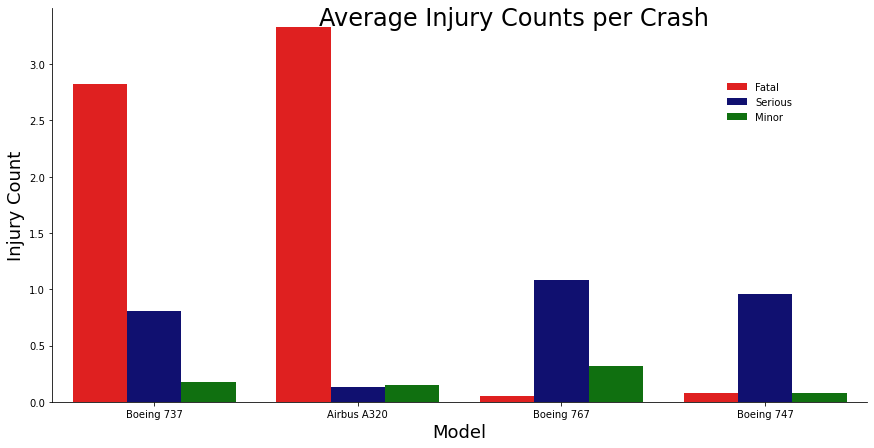

In [17]:
df_melted = commercial_planes.melt(id_vars='make_model', 
                                   value_vars=['avg_fatal_injuries', 'avg_serious_injuries', 'avg_minor_injuries'])

palette = {'avg_fatal_injuries': 'red', 
           'avg_serious_injuries': 'navy', 
           'avg_minor_injuries': 'green'}

plot = sns.catplot(data=df_melted, x='make_model', y='value', kind='bar', hue='variable', height=6, aspect=2, palette=palette)
plot.set_axis_labels('Model', 'Injury Count', fontsize=18)

plot._legend.set_title('')
# move legend
plot._legend.set_bbox_to_anchor((0.8, 0.8))
for t, l in zip(plot._legend.texts, ['Fatal', 'Serious', 'Minor']): 
    t.set_text(l)

plot.fig.suptitle('Average Injury Counts per Crash', fontsize=24)

# plot.savefig('plots/top_4_commercial.jpg');

# Boeing 767 and Boeing 747 seem to have the best overall fatality rate and injury counts

In [18]:
inclement_boeing.shape

NameError: name 'inclement_boeing' is not defined

In [ ]:
inclement_airbus.shape

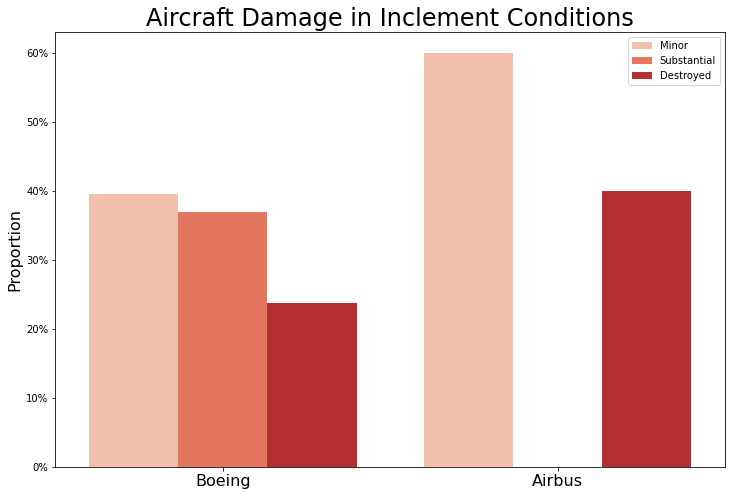

In [19]:
# drop "unknown" weather vals
weather_boeing = boeing_rows[boeing_rows['weather_condition'].isin(['VMC', 'IMC'])]
weather_airbus = airbus_rows[airbus_rows['weather_condition'].isin(['VMC', 'IMC'])]

# boeing v airbus in inclement weather
inclement_boeing = weather_boeing[weather_boeing['weather_condition'] == 'IMC']
inclement_airbus = weather_airbus[weather_airbus['weather_condition'] == 'IMC']

# drop "unknown" aircraft_damage vals
inclement_boeing = inclement_boeing[inclement_boeing['aircraft_damage'] != 'Unknown']
inclement_airbus = inclement_airbus[inclement_airbus['aircraft_damage'] != 'Unknown']

boeing_counts = inclement_boeing['aircraft_damage'].value_counts(normalize=True).reset_index()
boeing_counts.columns = ['aircraft_damage', 'proportion']
boeing_counts['company'] = 'Boeing'

airbus_counts = inclement_airbus['aircraft_damage'].value_counts(normalize=True).reset_index()
airbus_counts.columns = ['aircraft_damage', 'proportion']
airbus_counts['company'] = 'Airbus'

combined = pd.concat([boeing_counts, airbus_counts])

fig, ax = plt.subplots(figsize=(12, 8))

plot = sns.barplot(data=combined, x='company', y='proportion', hue='aircraft_damage', ax=ax, palette='Reds')

ax.set_title('Aircraft Damage in Inclement Conditions', fontsize=24)
locations = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%']
ax.set_yticks(locations)
ax.set_yticklabels(labels)
ax.legend(loc='upper right')

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)

plt.show()

fig.savefig('../plots/inclement.jpg');

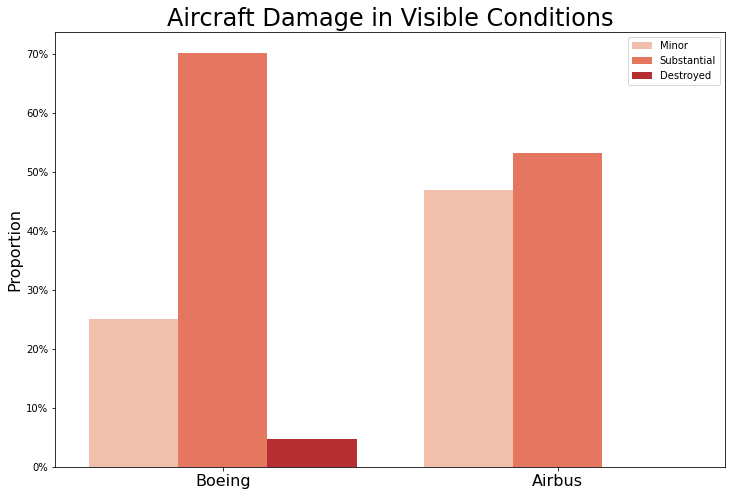

In [20]:
# boeing v airbus in normal weather
normal_boeing = weather_boeing[weather_boeing['weather_condition'] == 'VMC']
normal_airbus = weather_airbus[weather_airbus['weather_condition'] == 'VMC']

# drop "unknown" aircraft_damage vals
normal_boeing = normal_boeing[normal_boeing['aircraft_damage'] != 'Unknown']
normal_airbus = normal_airbus[normal_airbus['aircraft_damage'] != 'Unknown']

boeing_counts = normal_boeing['aircraft_damage'].value_counts(normalize=True).reset_index()
boeing_counts.columns = ['aircraft_damage', 'proportion']
boeing_counts['company'] = 'Boeing'

airbus_counts = normal_airbus['aircraft_damage'].value_counts(normalize=True).reset_index()
airbus_counts.columns = ['aircraft_damage', 'proportion']
airbus_counts['company'] = 'Airbus'

combined = pd.concat([boeing_counts, airbus_counts])

fig, ax = plt.subplots(figsize=(12, 8))

damage_order = ['Minor', 'Substantial', 'Destroyed']
sns.barplot(data=combined, x='company', y='proportion', hue='aircraft_damage', ax=ax, palette='Reds', hue_order=damage_order)

ax.set_title('Aircraft Damage in Visible Conditions', fontsize=24)
locations = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%']
ax.set_yticks(locations)
ax.set_yticklabels(labels)
ax.legend(loc='upper right')

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
plt.show()

fig.savefig('../plots/visible.jpg');

# Look into safety between 2 and 4 engines

In [21]:
combined

,aircraft_damage,proportion,company
0,Substantial,0.702055,Boeing
1,Minor,0.250000,Boeing
2,Destroyed,0.047945,Boeing
0,Substantial,0.531250,Airbus
1,Minor,0.468750,Airbus


In [22]:
# map max number_of_engines to each respective boeing model
true_engines = boeing_rows.groupby('model')['number_of_engines'].max()
boeing_rows.loc[boeing_rows['number_of_engines'] == 0, 'number_of_engines'] = boeing_rows['model'].map(true_engines)

# map max number_of_engines to each respective airbus model
true_engines = airbus_rows.groupby('model')['number_of_engines'].max()
airbus_rows.loc[airbus_rows['number_of_engines'] == 0, 'number_of_engines'] = airbus_rows['model'].map(true_engines)

C:\Users\heefj\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\heefj\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [23]:
# boeing engine counts
boeing_rows['number_of_engines'].value_counts()

2    1152
4     129
1     128
0     118
3      21
Name: number_of_engines, dtype: int64

In [24]:
# boeing engine counts
airbus_rows['number_of_engines'].value_counts()

2    245
0     17
4      6
Name: number_of_engines, dtype: int64

In [25]:
# grab rows where engines are either 2 or 4
boeing_2 = boeing_rows[boeing_rows['number_of_engines'] == 2]
boeing_4 = boeing_rows[boeing_rows['number_of_engines'] == 4]

airbus_2 = airbus_rows[airbus_rows['number_of_engines'] == 2]
airbus_4 = airbus_rows[airbus_rows['number_of_engines'] == 4]

# calculate fatality rate for each df
airbus_2['injury_severity'].value_counts(normalize=True)

non-fatal    0.955102
fatal        0.044898
Name: injury_severity, dtype: float64

In [26]:
# calculate 2-engine 
engine_2 = pd.concat([boeing_2, airbus_2])
engine_4 = pd.concat([boeing_4, airbus_4])

In [27]:
engine_2['injury_severity'].value_counts(normalize=True)

non-fatal    0.964925
fatal        0.035075
Name: injury_severity, dtype: float64

In [28]:
engine_4['injury_severity'].value_counts(normalize=True)

non-fatal    0.955556
fatal        0.044444
Name: injury_severity, dtype: float64

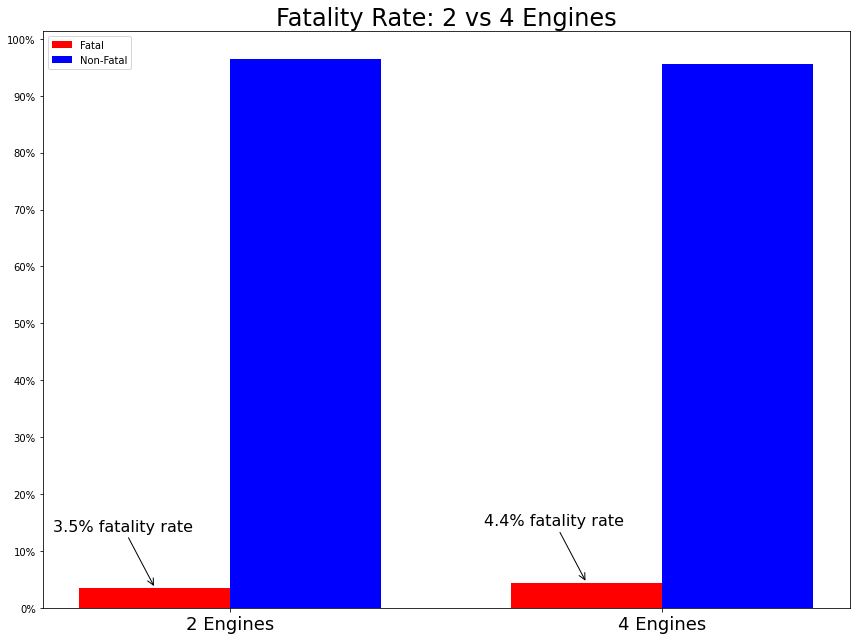

In [29]:
fig, ax = plt.subplots(figsize=(12,9))

# manually coding vals because i spent way too long on this
labels = ['2 Engines', '4 Engines']
fatal_values = [0.035075, 0.044444]
non_fatal_values = [0.964925, 0.955556]

bar_width = 0.35
index = np.arange(len(labels))

fatal_bars = plt.bar(index, fatal_values, bar_width, label='Fatal', color='r', align='center')
plt.bar(index + bar_width, non_fatal_values, bar_width, label='Non-Fatal', color='b', align='center')

# plt.ylabel('Fatality Rate', fontsize=20)
plt.title('Fatality Rate: 2 vs 4 Engines', fontsize=24)
plt.xticks(index + bar_width / 2, labels, fontsize=18)  # Setting the x-ticks in the middle of two bars
plt.yticks(np.arange(0, 1.1, 0.1), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.legend()

bar_height = fatal_bars[0].get_height()
plt.annotate(f'{bar_height:.1%} fatality rate', 
             xy=(fatal_bars[0].get_x() + fatal_bars[0].get_width() / 2, bar_height), 
             xytext=(fatal_bars[0].get_x() + 0.1, bar_height + 0.1), 
             arrowprops=dict(arrowstyle='->'),
             ha='center',
             fontsize=16)
bar_height = fatal_bars[1].get_height()
plt.annotate(f'{bar_height:.1%} fatality rate', 
             xy=(fatal_bars[1].get_x() + fatal_bars[1].get_width() / 2, bar_height), 
             xytext=(fatal_bars[1].get_x() + 0.1, bar_height + 0.1), 
             arrowprops=dict(arrowstyle='->'),
             ha='center',
             fontsize=16)

plt.tight_layout()
plt.show()

fig.savefig('../plots/engine_fatality.jpg');

In [30]:
engine_4.shape

(135, 21)

# Top 95 recorded private aircraft (1-9 seats)

- range from 47-815 accident records

In [38]:
private_planes = top_100.sort_values(by='num_seats').head(95)
private_planes

,make,model,count,fatality_rate,make_model,num_seats,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,avg_fatal_injuries,avg_serious_injuries,avg_minor_injuries,avg_uninjured,Substantial,Destroyed,Unknown,Minor
2185,Cessna,A188B,69,0.811594,Cessna A188B,1,13,7,7,41,0.188406,0.101449,0.101449,0.594203,0.855072,0.115942,0.014493,0.014493
280,Air Tractor,At502B,53,0.886792,Air Tractor At502B,1,6,4,7,41,0.113208,0.075472,0.132075,0.773585,0.849057,0.113208,0.000000,0.037736
284,Air Tractor,At602,53,0.735849,Air Tractor At602,1,14,7,4,28,0.264151,0.132075,0.075472,0.528302,0.867925,0.113208,0.018868,0.000000
278,Air Tractor,At502,74,0.729730,Air Tractor At502,1,21,14,7,32,0.283784,0.189189,0.094595,0.432432,0.797297,0.175676,0.027027,0.000000
267,Air Tractor,At301,60,0.900000,Air Tractor At301,1,6,12,5,37,0.100000,0.200000,0.083333,0.616667,0.916667,0.066667,0.016667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,Piper,Pa46,62,0.734375,Piper Pa46,6,39,15,13,139,0.629032,0.241935,0.209677,2.241935,0.734375,0.203125,0.046875,0.015625
6097,Piper,Pa44180,49,0.780000,Piper Pa44180,6,26,12,0,77,0.530612,0.244898,0.000000,1.571429,0.860000,0.100000,0.000000,0.040000
2346,Cessna,U206G,57,0.719298,Cessna U206G,6,37,35,12,83,0.649123,0.614035,0.210526,1.456140,0.807018,0.140351,0.000000,0.052632
2071,Cessna,208,76,0.644737,Cessna 208,9,96,35,53,237,1.263158,0.460526,0.697368,3.118421,0.697368,0.210526,0.078947,0.013158


In [39]:
# Seperate private planes by seat size (1 seat, 2-4 seats, 5-9 seats)
private_planes['seat_range'] = private_planes['num_seats'].map(lambda x: '1' if x == 1 else '2-4' if x < 5 else '5-9')
private_planes

,make,model,count,fatality_rate,make_model,num_seats,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,avg_fatal_injuries,avg_serious_injuries,avg_minor_injuries,avg_uninjured,Substantial,Destroyed,Unknown,Minor,seat_range
2185,Cessna,A188B,69,0.811594,Cessna A188B,1,13,7,7,41,0.188406,0.101449,0.101449,0.594203,0.855072,0.115942,0.014493,0.014493,1
280,Air Tractor,At502B,53,0.886792,Air Tractor At502B,1,6,4,7,41,0.113208,0.075472,0.132075,0.773585,0.849057,0.113208,0.000000,0.037736,1
284,Air Tractor,At602,53,0.735849,Air Tractor At602,1,14,7,4,28,0.264151,0.132075,0.075472,0.528302,0.867925,0.113208,0.018868,0.000000,1
278,Air Tractor,At502,74,0.729730,Air Tractor At502,1,21,14,7,32,0.283784,0.189189,0.094595,0.432432,0.797297,0.175676,0.027027,0.000000,1
267,Air Tractor,At301,60,0.900000,Air Tractor At301,1,6,12,5,37,0.100000,0.200000,0.083333,0.616667,0.916667,0.066667,0.016667,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,Piper,Pa46,62,0.734375,Piper Pa46,6,39,15,13,139,0.629032,0.241935,0.209677,2.241935,0.734375,0.203125,0.046875,0.015625,5-9
6097,Piper,Pa44180,49,0.780000,Piper Pa44180,6,26,12,0,77,0.530612,0.244898,0.000000,1.571429,0.860000,0.100000,0.000000,0.040000,5-9
2346,Cessna,U206G,57,0.719298,Cessna U206G,6,37,35,12,83,0.649123,0.614035,0.210526,1.456140,0.807018,0.140351,0.000000,0.052632,5-9
2071,Cessna,208,76,0.644737,Cessna 208,9,96,35,53,237,1.263158,0.460526,0.697368,3.118421,0.697368,0.210526,0.078947,0.013158,5-9


# Fatality rates range from 3% - 56%

- Fatality rate
- Chance of death upon crash

In [40]:
private_planes['fatality_rate'].describe()

count    95.000000
mean      0.788911
std       0.104501
min       0.516667
25%       0.718623
50%       0.789474
75%       0.879924
max       0.966102
Name: fatality_rate, dtype: float64

NameError: name 'private_planes' is not defined

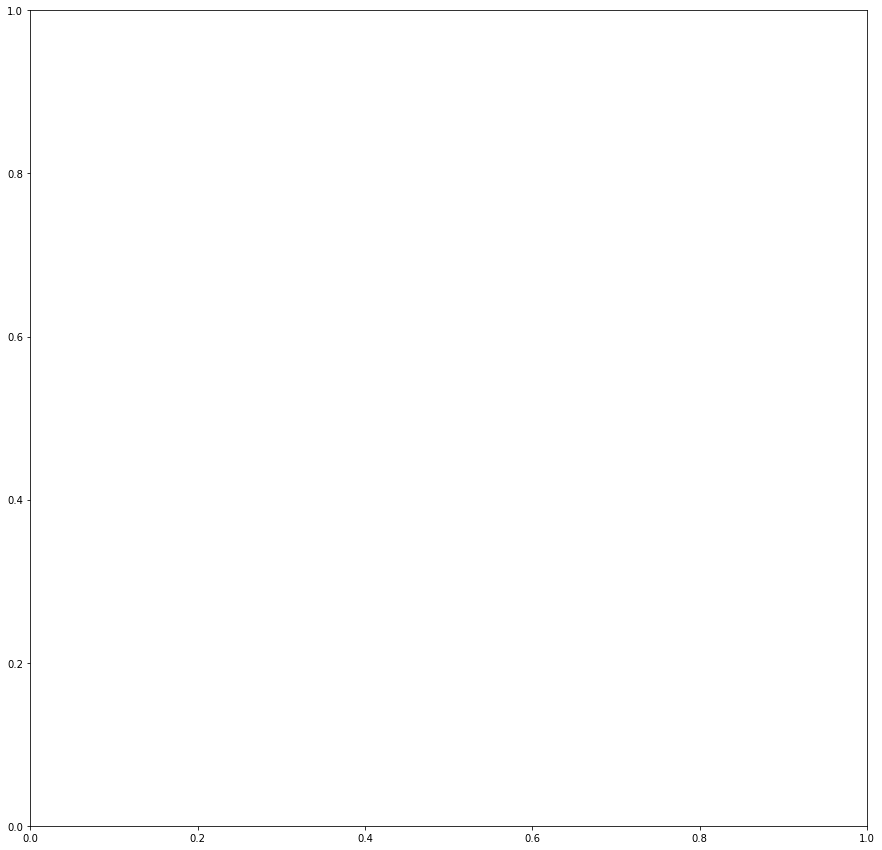

In [31]:
x = 50
fig, ax = plt.subplots(figsize=(15,15))

sorted_data = private_planes.sort_values(by='fatality_rate').head(x)
sns.barplot(data=sorted_data, x='fatality_rate', y='make_model', hue='seat_range', orient='h', dodge=False)

ax.set_xlabel('Fatality rate', fontsize=16)
ax.set_ylabel('Model', fontsize=16)
ax.set_title(f'Top {x} Lowest Private Aircraft Fatality Rates', fontsize=22)

ax.legend().set_title('number of seats');